# Distribuições de Probabilidade e Amostragem

## Probabilidade de alguém ser usuário de uma operadora de telefonia

Qual é a probabilidade de uma pessoa no Brasil ser cliente da VIVO, CLARO ou TIM?

Fonte: https://sistemas.anatel.gov.br/anexar-api/publico/anexos/download/44aaef993685036f18cab2ea0b4561e2

Sendo que o percentual do mercado já foi calculado, iremos apenas normalizar o percentual para somar 1.

Se considerarmos a população do país de 213.421.037 habitantes (https://www.ibge.gov.br/), podemos multiplicar a probabilidade pela quantidade total de habitantes e inferir a quantidade de usuários de determinada operadora.

In [8]:
import pandas as pd

# Caminho do arquivo CSV
csv_path = 'Aula2/julio/Operadoradetelefonia-Pctmercado-Perodo.csv'

# Lê o CSV em um DataFrame
df = pd.read_csv(csv_path)

# Adiciona a coluna "P" como probabilidade (percentual dividido por 100)
df['P'] = df['Pct mercado'] / 100

# Exibe o DataFrame resultante
# print(df)

# Filtra apenas pelo período "2T2025"
filtered_df = df[df['Período'] == '2T2025']
print(filtered_df)

# Some todas as probabilidades de filtered_df
total_probability = filtered_df['P'].sum()
print(f'Probabilidade total deve somar 1: {total_probability}')

# Salve o DataFrame filtrado em um novo CSV
filtered_csv_path = 'Aula2/julio/Operadoradetelefonia-Pctmercado-2T2025.csv'
filtered_df.to_csv(filtered_csv_path, index=False)

   Operadora de telefonia  Pct mercado Período       P
1                    VIVO        38.50  2T2025  0.3850
3                   CLARO        32.52  2T2025  0.3252
5                     TIM        23.40  2T2025  0.2340
7                   ALGAR         1.68  2T2025  0.0168
9                  Datora         1.13  2T2025  0.0113
11                   SURF         0.93  2T2025  0.0093
13             Next Level         0.42  2T2025  0.0042
15              Teleports         0.32  2T2025  0.0032
17               BRISANET         0.09  2T2025  0.0009
19                   VERO         0.08  2T2025  0.0008
21               UNIFIQUE         0.06  2T2025  0.0006
23                  LIGGA         0.01  2T2025  0.0001
Probabilidade total deve somar 1: 0.9914000000000002


In [12]:
# Lê o CSV filtrado em um novo DataFrame
df = pd.read_csv(filtered_csv_path)

# crie uma nova coluna "Estimated Users" que multiplica a probabilidade "P" pela população total do Brasil (213421037)
population_brazil = 213421037
df['Estimated Users'] = df['P'] * population_brazil
print(df)
print('+82 bilhões de usuários da VIVO no Brasil')

   Operadora de telefonia  Pct mercado Período       P  Estimated Users
0                    VIVO        38.50  2T2025  0.3850     8.216710e+07
1                   CLARO        32.52  2T2025  0.3252     6.940452e+07
2                     TIM        23.40  2T2025  0.2340     4.994052e+07
3                   ALGAR         1.68  2T2025  0.0168     3.585473e+06
4                  Datora         1.13  2T2025  0.0113     2.411658e+06
5                    SURF         0.93  2T2025  0.0093     1.984816e+06
6              Next Level         0.42  2T2025  0.0042     8.963684e+05
7               Teleports         0.32  2T2025  0.0032     6.829473e+05
8                BRISANET         0.09  2T2025  0.0009     1.920789e+05
9                    VERO         0.08  2T2025  0.0008     1.707368e+05
10               UNIFIQUE         0.06  2T2025  0.0006     1.280526e+05
11                  LIGGA         0.01  2T2025  0.0001     2.134210e+04
+82 bilhões de usuários da VIVO no Brasil



No SGBD clickhouse, criar um DB IBGE

https://clickhouse.com/docs/knowledgebase/importing-geojason-with-nested-object-array#question
https://sidra.ibge.gov.br/home/pnadct/brasil
https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/26565-malhas-de-setores-censitarios-divisoes-intramunicipais.html


- carregar shape (geojson)
- fazer operações geoespacias
- fazer JOIN e mostrar distribuições

### Descomprimir e mover para a pasta de leitura do clickhouse

```bash
cd /workspaces/Stats-In-Codespace/Aula2/julio
unzip BR_Municipios_2024.geojson.zip
sudo mv BR_Municipios_2024.geojson /var/lib/clickhouse/user_files
```

Depois de entrar no clickhouse-client:

```sql
DESCRIBE TABLE file('BR_Municipios_2024.geojson', 'JSON')
```

Vemos:
```bash
DESCRIBE TABLE file('BR_Municipios_2024.geojson', 'JSON')

Query id: 69b90589-8b43-4dbf-b461-b98de6c61636

Row 1:
──────
name:               type
type:               Nullable(String)
default_type:       
default_expression: 
comment:            
codec_expression:   
ttl_expression:     

Row 2:
──────
name:               name
type:               Nullable(String)
default_type:       
default_expression: 
comment:            
codec_expression:   
ttl_expression:     

Row 3:
──────
name:               features
type:               Array(Tuple(
    geometry Tuple(
        coordinates Array(Array(Array(Array(Nullable(Float64))))),
        type Nullable(String)),
    properties Tuple(
        AREA_KM2 Nullable(Float64),
        CD_CONCU Nullable(String),
        CD_MUN Nullable(String),
        CD_REGIA Nullable(String),
        CD_RGI Nullable(String),
        CD_RGINT Nullable(String),
        CD_UF Nullable(String),
        NM_CONCU Nullable(String),
        NM_MUN Nullable(String),
        NM_REGIA Nullable(String),
        NM_RGI Nullable(String),
        NM_RGINT Nullable(String),
        NM_UF Nullable(String),
        SIGLA_RG Nullable(String),
        SIGLA_UF Nullable(String)),
    type Nullable(String)))
default_type:       
default_expression: 
comment:            
codec_expression:   
ttl_expression:     

3 rows in set. Elapsed: 9.143 sec. 
```

Criar a tabela:

```sql
create database ibge;
use ibge;
CREATE TABLE br_municipios
(
    type String,
    name String,
    featureType String,
    
    -- Dados do município
    cd_mun String,
    nm_mun String,
    area_km2 Float64,
    
    -- Dados da UF
    cd_uf String,
    nm_uf String,
    sigla_uf String,
    
    -- Dados regionais
    cd_concu Nullable(String),
    nm_concu Nullable(String),
    cd_regia Nullable(String),
    nm_regia Nullable(String),
    cd_rgi Nullable(String),
    nm_rgi Nullable(String),
    cd_rgint Nullable(String),
    nm_rgint Nullable(String),
    sigla_rg Nullable(String),
    
    -- Geometria
    geometryType String,
    geometry MultiPolygon
)
ENGINE = MergeTree
ORDER BY (cd_uf, cd_mun);
```

Verificando antes de inserir.

```sql
SELECT
    type,
    name,
    features.type AS featureType,
    features.properties.CD_MUN AS cd_mun,
    features.properties.NM_MUN AS nm_mun,
    features.properties.SIGLA_UF AS sigla_uf,
    features.geometry.type AS geometryType
FROM file('BR_Municipios_2024.geojson', 'JSON')
ARRAY JOIN features
LIMIT 5;
```

Inserindo os dados:
```sql
INSERT INTO br_municipios
SELECT
    type,
    name,
    features.type AS featureType,
    
    -- Dados do município
    features.properties.CD_MUN AS cd_mun,
    features.properties.NM_MUN AS nm_mun,
    features.properties.AREA_KM2 AS area_km2,
    
    -- Dados da UF
    features.properties.CD_UF AS cd_uf,
    features.properties.NM_UF AS nm_uf,
    features.properties.SIGLA_UF AS sigla_uf,
    
    -- Dados regionais
    features.properties.CD_CONCU AS cd_concu,
    features.properties.NM_CONCU AS nm_concu,
    features.properties.CD_REGIA AS cd_regia,
    features.properties.NM_REGIA AS nm_regia,
    features.properties.CD_RGI AS cd_rgi,
    features.properties.NM_RGI AS nm_rgi,
    features.properties.CD_RGINT AS cd_rgint,
    features.properties.NM_RGINT AS nm_rgint,
    features.properties.SIGLA_RG AS sigla_rg,
    
    -- Geometria
    features.geometry.type AS geometryType,
    arrayMap(
        poly -> arrayMap(
            ring -> arrayMap(
                coord -> (coord[1], coord[2]),
                ring
            ),
            poly
        ),
        features.geometry.coordinates
    ) AS geometry
FROM file('BR_Municipios_2024.geojson', 'JSON')
ARRAY JOIN features;
```

Verificar:

```sql
-- Contar registros
SELECT count(*) FROM br_municipios;

-- Verificar o tipo da geometria
SELECT DISTINCT toTypeName(geometry) FROM br_municipios;

-- Ver alguns municípios por estado
SELECT sigla_uf, count(*) AS total_municipios
FROM br_municipios
GROUP BY sigla_uf
ORDER BY sigla_uf;
```

### calculando o centroide de cada polígono

```sql
-- Função auxiliar para calcular área usando a fórmula shoelace
CREATE FUNCTION area AS (v1, v2) -> 
    ((v1.1 * v2.2) - (v2.1 * v1.2));

-- Função para calcular a área assinada do polígono
CREATE FUNCTION signed_area AS polygon ->
    arrayFold(
        (acc, x) -> (
            (acc.1) + ((((x.1).1) + ((polygon[((x.2) + 1) % (length(polygon) + 1)]).1)) 
                * area(x.1, polygon[((x.2) + 1) % (length(polygon) + 1)])),
            (acc.2) + ((((x.1).2) + ((polygon[((x.2) + 1) % (length(polygon) + 1)]).2)) 
                * area(x.1, polygon[((x.2) + 1) % (length(polygon) + 1)])),
            (acc.3) + area(x.1, polygon[((x.2) + 1) % (length(polygon) + 1)])
        ),
        arrayZip(polygon, range(1, length(polygon) + 1)),
        (0.0, 0.0, 0.0)
    );

-- Função principal para calcular o centroide
CREATE FUNCTION centroid AS polygon -> (
    (signed_area(polygon).1) / ((6 * (signed_area(polygon).3)) * 0.5),
    (signed_area(polygon).2) / ((6 * (signed_area(polygon).3)) * 0.5)
);
```

### Calcular Centroides para Cada Município

Opção 1: Adicionar Colunas à Tabela Existente
```sql
-- Adicionar colunas para longitude e latitude do centroide
ALTER TABLE br_municipios 
    ADD COLUMN centroid_lon Float64,
    ADD COLUMN centroid_lat Float64;

-- Calcular e atualizar os centroides
-- Nota: Para MultiPolygon, usamos o primeiro polígono (principal)
ALTER TABLE br_municipios 
UPDATE 
    centroid_lon = centroid(geometry[1][1]).1,
    centroid_lat = centroid(geometry[1][1]).2
WHERE 1=1;
```
Opção 2: Consulta Direta
```sql
SELECT 
    cd_mun,
    nm_mun,
    sigla_uf,
    
    -- Centroide do primeiro polígono (principal)
    centroid(geometry[1][1]).1 AS centroid_lon,
    centroid(geometry[1][1]).2 AS centroid_lat,
    
    -- Ou como tupla (Point)
    centroid(geometry[1][1]) AS centroid_point,
    
    area_km2
FROM br_municipios
ORDER BY sigla_uf, nm_mun
LIMIT 10;
```
Verificar os Resultados
```sql
-- Ver alguns exemplos
SELECT 
    nm_mun,
    sigla_uf,
    round(centroid_lon, 6) AS longitude,
    round(centroid_lat, 6) AS latitude
FROM br_municipios
WHERE sigla_uf = 'RJ'
ORDER BY nm_mun
LIMIT 5;
```
Criar Vista com Centroides
```sql
CREATE VIEW municipios_com_centroides AS
SELECT 
    *,
    centroid(geometry[1][1]).1 AS centroid_lon,
    centroid(geometry[1][1]).2 AS centroid_lat
FROM br_municipios;
```


Carregando um arquivo CSV

## População por municipio em 2025 - fonte https://sidra.ibge.gov.br/tabela/6579

tabela6579.CSV

file -i tabela6579.csv 
tabela6579.csv: text/plain; charset=iso-8859-1

Converte para UTF8

iconv -f iso-8859-1 -t utf8 tabela6579.csv > tabela6579utf8.csv

Criar tabela no DB
```sql
Use ibge;
CREATE TABLE IF NOT EXISTS municipio6579
(
    codigo String,
    municipio String,
    populacao UInt32
)
ENGINE = MergeTree()
ORDER BY codigo;
```

### Remover o cabeçalho e importar

```bash
clickhouse-client --query="INSERT INTO ibge.municipio6579 FORMAT CSV" --format_csv_delimiter=";" --input_format_skip_unknown_fields=1 < <(tail -n +2 tabela6579utf8.csv)
```

Agora podemos fazer um JOIN das tabelas e descobrir a população por município.

```sql
select
  mm.area_km2, m.populacao
from
  br_municipios mm inner join municipio6579 m
  on mm.cd_mun = m.codigo;
```


## Tabela 8114 - Pessoas de 15 anos ou mais de idade, ocupadas na semana de referência, que se deslocava da casa para o trabalho, por tempo de deslocamento por dia e situação do domicílio - https://sidra.ibge.gov.br/Tabela/8114

## Tabela 10333 - Pessoas de 10 anos ou mais de idade, ocupadas na semana de referência, que, no trabalho principal, trabalhavam fora do domicílio, por tempo habitual de deslocamento do domicílio para o trabalho principal, nível de instrução, grupo de idade e cor ou raça - https://sidra.ibge.gov.br/Tabela/10333

Tabela 10333 - Pessoas de 10 anos ou mais de idade, ocupadas na semana de referência, que, no trabalho principal, trabalhavam fora do domicílio, por tempo habitual de deslocamento do domicílio para o trabalho principal, nível de instrução, grupo de idade e cor ou raça								
Cor ou raça - Total								
Nível de instrução - Total								
Grupo de idade - Total								
Ano - 2022								
Variável - Pessoas de 10 anos ou mais de idade, ocupadas na semana de referência, que, no trabalho principal, trabalhavam fora do domicílio (Pessoas)								

*Tempo habitual de deslocamento do domicílio para o trabalho principal*

```sql
Use ibge;
CREATE TABLE IF NOT EXISTS casatrabalho10333
(
    codigo String,
    municipio String,
    ate5min UInt32,
    d6ate15m UInt32,
    d15ate30m UInt32,
    d30mate1h UInt32,
    d1ate2h UInt32,
    d2ate4h UInt32,
    m4h UInt32
)
ENGINE = MergeTree()
ORDER BY codigo;
```

O arquivo do IBGE possui "-" no lugar de valores nulos. Para carregar no banco de dados precisamos substituir os "-" por "0" (zero), mas apenas quando o traço for precedido de ";".

```bash
sed 's/;-/;0/g' tabela10333utf8.csv > tabela10333utf8v2.csv
```

Removi a última linha manualmente, que possui um texto descritivo.

### Remover o cabeçalho e importar

```bash
clickhouse-client --query="INSERT INTO ibge.casatrabalho10333 FORMAT CSV" --format_csv_delimiter=";" --input_format_skip_unknown_fields=1 < <(tail -n +2 tabela10333utf8v2.csv)
```

### Podemos montar algumas distribuições

#### qtd de pessoas vs qtd de horas até o trabalho


```sql
SELECT
    m.populacao,
    ct.ate5min
FROM municipio6579 m inner join casatrabalho10333 ct on ct.codigo = m.codigo
ORDER BY m.populacao
LIMIT 30;
```


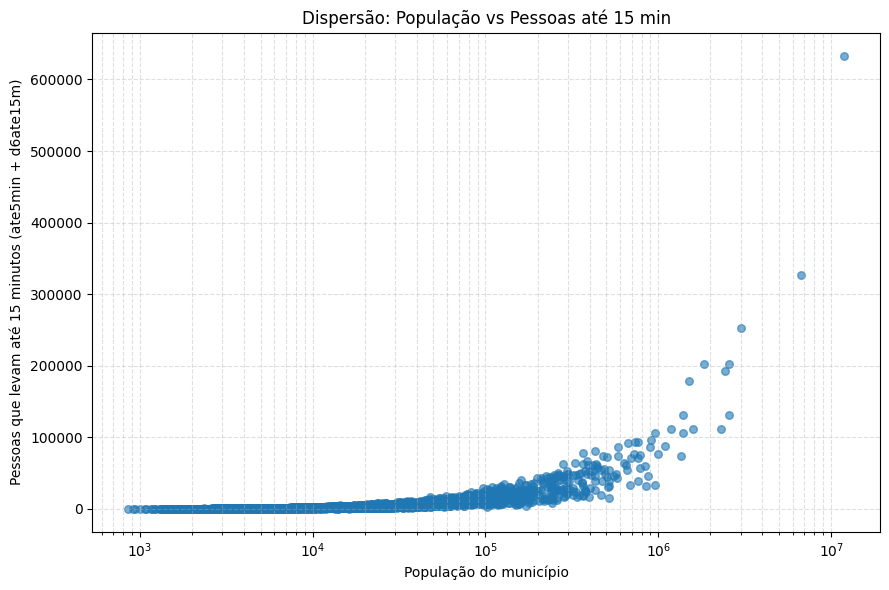

In [ ]:
# Quantidade de pessoas que chegam em até 15 minutos ao trabalho vs população do município
# testar com clickhouse_connect
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt

# Configurar conexão com ClickHouse (ajuste host, user, password conforme seu ambiente)
client = Client(host='localhost', user='default', password='785498')

# Query SQL
query = """
SELECT
    m.populacao,
    ct.ate5min,
    ct.d6ate15m
FROM ibge.municipio6579 m
INNER JOIN ibge.casatrabalho10333 ct ON ct.codigo = m.codigo
ORDER BY m.populacao
"""

rows, columns_info = client.execute(
    query,
    with_column_types=True,
    columnar=False   # <--- isso elimina completamente a necessidade do extra NumPy
)

column_names = [col[0] for col in columns_info]

df_q = pd.DataFrame(rows, columns=column_names)

# Garantir colunas numéricas e computar "até 15 min" (até 5 + 6-15)
df_q['populacao'] = pd.to_numeric(df_q['populacao'], errors='coerce')
df_q['ate5min'] = pd.to_numeric(df_q.get('ate5min', 0), errors='coerce').fillna(0)
df_q['d6ate15m'] = pd.to_numeric(df_q.get('d6ate15m', 0), errors='coerce').fillna(0)
df_q['ate_ate15min'] = df_q['ate5min'] + df_q['d6ate15m']
df_q = df_q.dropna(subset=['populacao', 'ate_ate15min'])

# Plot
plt.figure(figsize=(9,6))
plt.scatter(df_q['populacao'], df_q['ate_ate15min'], alpha=0.6, s=30)
plt.xscale('log')  # opcional: melhora visualização quando há muitos municípios pequenos
plt.xlabel('População do município')
plt.ylabel('Pessoas que levam até 15 minutos (ate5min + d6ate15m)')
plt.title('Dispersão: População vs Pessoas até 15 min')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

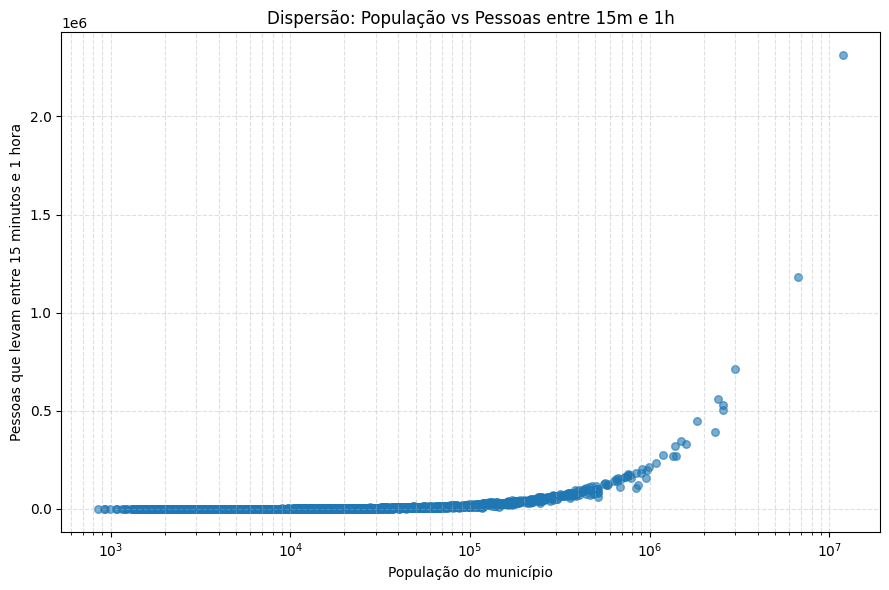

In [5]:
# Quantidade de pessoas que chegam no trabalho entre 15 minutos e 1 hora vs população do município

from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt

# Configurar conexão com ClickHouse (ajuste host, user, password conforme seu ambiente)
client = Client(host='localhost', user='default', password='785498')

# Query SQL
query = """
SELECT
    m.populacao,
    ct.d15ate30m,
    ct.d30mate1h
FROM ibge.municipio6579 m
INNER JOIN ibge.casatrabalho10333 ct ON ct.codigo = m.codigo
ORDER BY m.populacao
"""

rows, columns_info = client.execute(
    query,
    with_column_types=True,
    columnar=False
)

column_names = [col[0] for col in columns_info]

df_q = pd.DataFrame(rows, columns=column_names)

# Garantir colunas numéricas e computar (entre 15m e 1h)
df_q['populacao'] = pd.to_numeric(df_q['populacao'], errors='coerce')
df_q['d15ate30m'] = pd.to_numeric(df_q.get('d15ate30m', 0), errors='coerce').fillna(0)
df_q['d30mate1h'] = pd.to_numeric(df_q.get('d30mate1h', 0), errors='coerce').fillna(0)
df_q['entre15me1h'] = df_q['d15ate30m'] + df_q['d30mate1h']
df_q = df_q.dropna(subset=['populacao', 'entre15me1h'])

# Plot
plt.figure(figsize=(9,6))
plt.scatter(df_q['populacao'], df_q['entre15me1h'], alpha=0.6, s=30)
plt.xscale('log')  # opcional: melhora visualização quando há muitos municípios pequenos
plt.xlabel('População do município')
plt.ylabel('Pessoas que levam entre 15 minutos e 1 hora')
plt.title('Dispersão: População vs Pessoas entre 15m e 1h')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

   ate5min  d6ate15m  d15ate30m  d30mate1h  d1ate2h  d2ate4h  m4h
0     1547      2187       1204        588      523       27    9
1     4868     16739      10126       1976     1396      352  442
2      555       475        368        140       49        7    0
3     5635     14268       8563       1882      715      127  202
4     1658      2659       1017        429      178       52   45


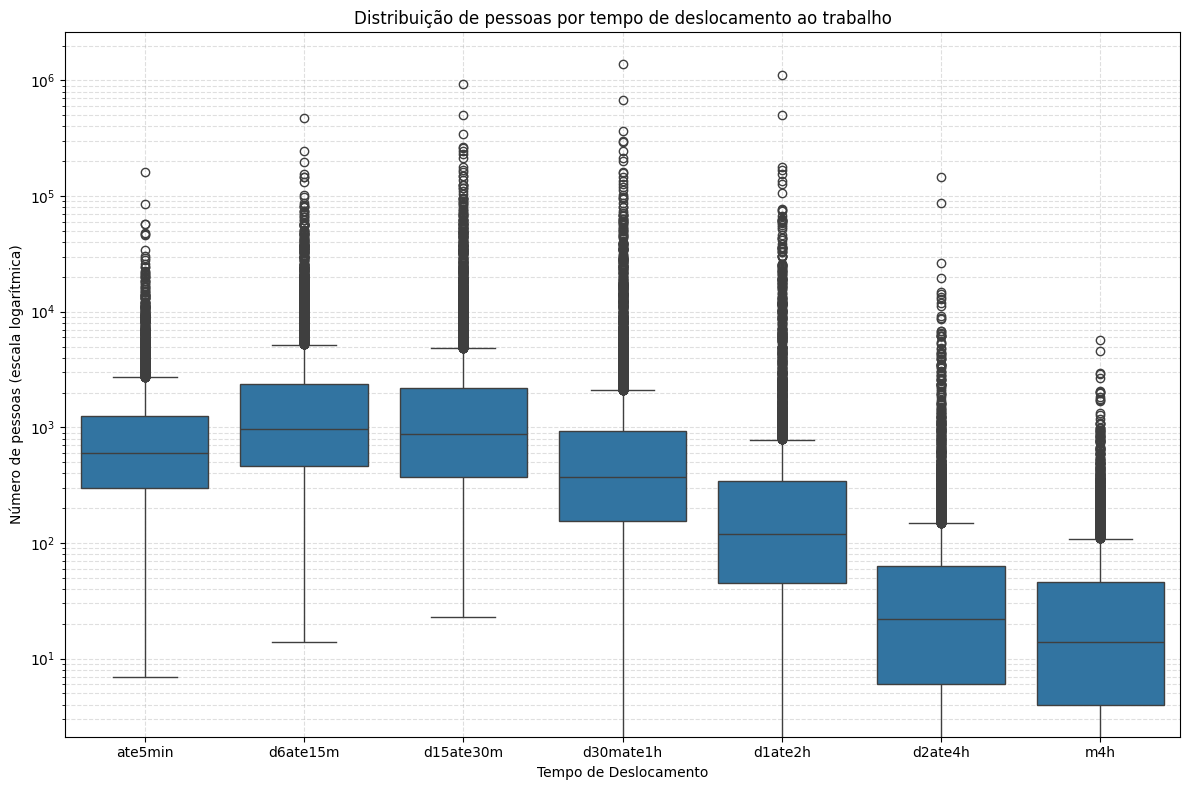

# Fonte: IBGE - Censo Demográfico 2022
# Download de https://sidra.ibge.gov.br/Tabela/10333
Cada ponto representa um município brasileiro em cada boxplot.


In [5]:
# Com boxplot comparar as distribuições de quantidade de pessoas por tempo de deslocamento ao trabalho
# cada categoria de tempo (até 5 min, 6-15 min, 15-30 min, 30m-1h, etc.) em uma coluna de boxplot

# Script para gerar boxplot das distribuições de quantidade de pessoas por tempo de deslocamento ao trabalho

import clickhouse_connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Configurar conexão com ClickHouse (ajuste host, username, password conforme seu ambiente)
client = clickhouse_connect.get_client(host='localhost', username='default', password='785498', database='ibge')
# Query SQL
query = """
SELECT
    ct.ate5min,
    ct.d6ate15m,
    ct.d15ate30m,
    ct.d30mate1h,
    ct.d1ate2h,
    ct.d2ate4h,
    ct.m4h
FROM ibge.casatrabalho10333 ct
"""
# Lê diretamente para DataFrame (muito mais rápido)
df = client.query_df(query)
print(df.head())
# Transformar o DataFrame para formato longo
df_melted = df.melt(var_name='Tempo de Deslocamento', value_name='Número de Pessoas')
# Plot boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Tempo de Deslocamento', y='Número de Pessoas', data=df_melted)
plt.yscale('log')  # opcional: melhora visualização
plt.ylabel('Número de pessoas (escala logarítmica)')
plt.title('Distribuição de pessoas por tempo de deslocamento ao trabalho')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()
print("# Fonte: IBGE - Censo Demográfico 2022")
print("# Download de https://sidra.ibge.gov.br/Tabela/10333")
print("Cada ponto representa um município brasileiro em cada boxplot.")

In [3]:
# Quais são os outliers em cada categoria?
outliers = {}
for column in df.columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column].tolist()

print("Outliers por categoria de tempo de deslocamento:")
for category, values in outliers.items():
    print(f"{category}: {values}")


Outliers por categoria de tempo de deslocamento:
ate5min: [4868, 5635, 2901, 5512, 13093, 3793, 4316, 4375, 10912, 4210, 4474, 4292, 30348, 3554, 4024, 5507, 13465, 5306, 5594, 8058, 4284, 25786, 5470, 5480, 4994, 3632, 3377, 6628, 4798, 8241, 2729, 4964, 6569, 4671, 9506, 2765, 3135, 4302, 3038, 13656, 4562, 6416, 5194, 3171, 3570, 16255, 4152, 4967, 4734, 3837, 6343, 3251, 4030, 3380, 8811, 2963, 3433, 4281, 2901, 4294, 22283, 4298, 3265, 6404, 4395, 3058, 2755, 22170, 3575, 4439, 3055, 3184, 3737, 8063, 4195, 3862, 57148, 3162, 2960, 4806, 4751, 9305, 3584, 6045, 3448, 3706, 4350, 4242, 3065, 3061, 7570, 3267, 3934, 4369, 3142, 6479, 10031, 19800, 2938, 13870, 3078, 21193, 5207, 3075, 3226, 3322, 2887, 11843, 4409, 2776, 2797, 9209, 5396, 5051, 12988, 28194, 4369, 4216, 2745, 3669, 7745, 20163, 13988, 6135, 4604, 3026, 2933, 3463, 6348, 2837, 6455, 3260, 4376, 11778, 3900, 4641, 3456, 2984, 5693, 2928, 2866, 2997, 5113, 7246, 4146, 5276, 4149, 6915, 2882, 34322, 3727, 3218, 5781, 27

# Carregar tabela 5881 - Pessoas de 10 anos ou mais de idade, ocupadas na semana de referência, que, no trabalho principal, trabalhavam fora do domicílio, por tempo habitual de deslocamento do domicílio para o trabalho principal, posição na ocupação, grupo de idade e cor ou raça - Total Brasil
# https://sidra.ibge.gov.br/Tabela/5881
# Variável - Pessoal ocupado na administração direta (Unidades)		
# Vínculo empregatício - Total		
# Ano - 2023		

Converte para UTF8

iconv -f iso-8859-1 -t utf8 tabela5881.csv > tabela5881utf8.csv

Criar tabela no DB
```sql
Use ibge;
CREATE TABLE IF NOT EXISTS pessoas_ocupadas5881
(
    codigo String,
    municipio String,
    pessoas_ocupadas UInt32
)
ENGINE = MergeTree()
ORDER BY codigo;
```

O arquivo do IBGE possui "-" no lugar de valores nulos. Para carregar no banco de dados precisamos substituir os "-" por "0" (zero), mas apenas quando o traço for precedido de ";".

```bash
sed 's/;-/;0/g' tabela5881utf8.csv > tabela5881utf8v2.csv
```

### Remover o cabeçalho e importar

```bash
clickhouse-client --query="INSERT INTO ibge.pessoas_ocupadas5881 FORMAT CSV" --format_csv_delimiter=";" --input_format_skip_unknown_fields=1 < <(tail -n +2 tabela5881utf8v2.csv)
```


                     municipio   m4h  pessoas_ocupadas  proporcao_m4h
0   Serranópolis de Minas (MG)   232              1141       0.203330
1                  Chaves (PA)   640              3422       0.187025
2                  Lastro (PB)    52               316       0.164557
3         Tenente Ananias (RN)   282              1817       0.155201
4     Riacho dos Machados (MG)   351              2716       0.129234
..                         ...   ...               ...            ...
95  São João do Jaguaribe (CE)    69              1434       0.048117
96          Santa Brígida (BA)   159              3324       0.047834
97            Major Sales (RN)    44               922       0.047722
98               Itaituba (PA)  1828             38311       0.047715
99             Itacarambi (MG)   235              4949       0.047484

[100 rows x 4 columns]


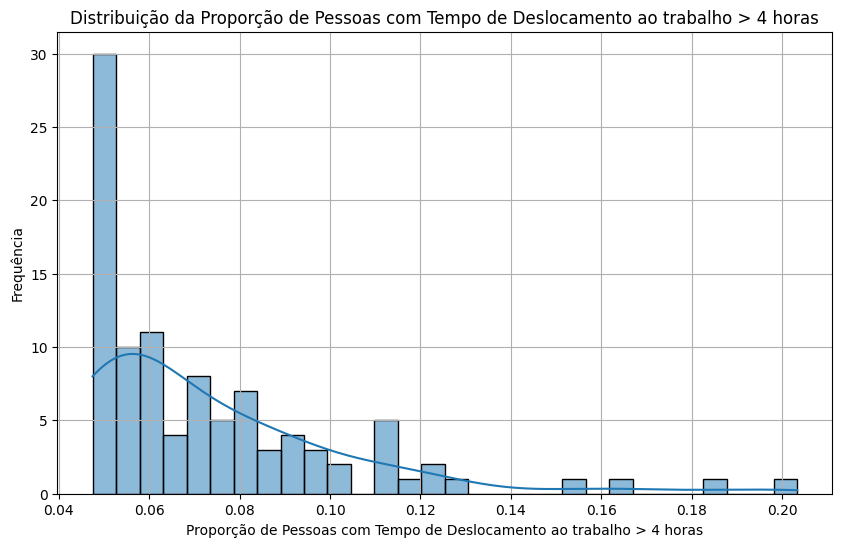

In [ ]:
# Quais são os top 100 municípios com pior tempo de deslocamento na faixa m4h?
# Considerando a quantidade de pessoas proporcionais ao total de pessoas que trabalham no município

import clickhouse_connect
import pandas as pd

# Configurar conexão com ClickHouse (ajuste host, username, password conforme seu ambiente)
client = clickhouse_connect.get_client(host='localhost', username='default', password='785498', database='ibge')

# Query SQL
query = """
SELECT
    ct.municipio,
    ct.m4h,
    po.pessoas_ocupadas,
    (ct.m4h / po.pessoas_ocupadas) AS proporcao_m4h
FROM ibge.casatrabalho10333 ct inner JOIN ibge.pessoas_ocupadas5881 po
ON ct.codigo = po.codigo
ORDER BY proporcao_m4h DESC
LIMIT 100
"""

# Pode usar o somatório de todos os tempos = pessoas ocupadas se preferir
# faz mais sentido para o cálculo da proporção
query = """
SELECT
    ct.municipio,
    ct.m4h,
    ct.ate5min + ct.d6ate15m + ct.d15ate30m + ct.d30mate1h + ct.d1ate2h + ct.d2ate4h + ct.m4h AS pessoas_ocupadas,
    (ct.m4h / (ct.ate5min + ct.d6ate15m + ct.d15ate30m + ct.d30mate1h + ct.d1ate2h + ct.d2ate4h + ct.m4h)) AS proporcao_m4h
FROM ibge.casatrabalho10333 ct 
ORDER BY proporcao_m4h DESC
LIMIT 100
"""

# Lê diretamente para DataFrame (muito mais rápido)
df = client.query_df(query)
print(df)

# Visualizar a distribuição da proporção de pessoas com tempo de deslocamento maior que 4 horas
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['proporcao_m4h'], bins=30, kde=True)
plt.title('Distribuição da Proporção de Pessoas com Tempo de Deslocamento ao trabalho > 4 horas')
plt.xlabel('Proporção de Pessoas com Tempo de Deslocamento ao trabalho > 4 horas')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()  

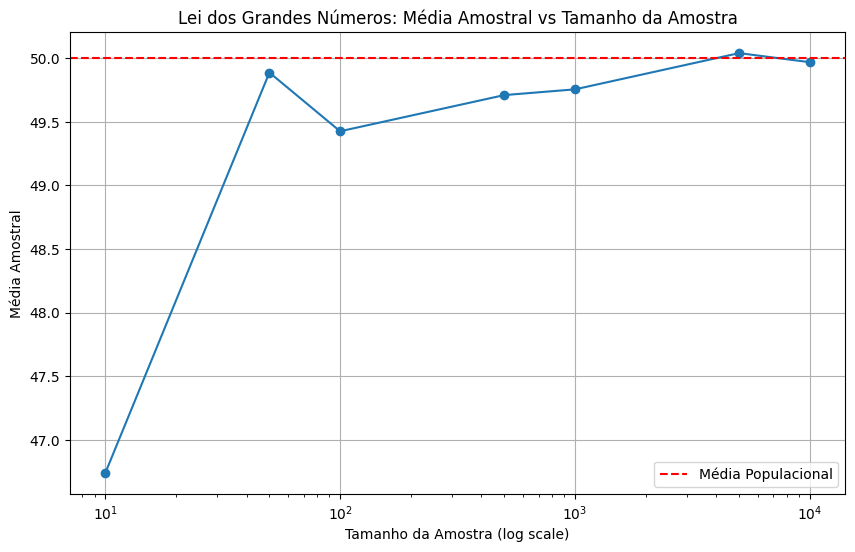

In [1]:
# Lei dos Grande Números: À medida que o tamanho da amostra aumenta, 
#   a média amostral se aproxima da média populacional.
# Simulação em Python
import numpy as np
import matplotlib.pyplot as plt
# Parâmetros da simulação
population_mean = 50
population_std = 10
population_size = 100000
# Gerar população
population = np.random.normal(population_mean, population_std, population_size)
# Tamanhos de amostra para testar
sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000]
# Armazenar médias amostrais
sample_means = []
for size in sample_sizes:
    sample = np.random.choice(population, size=size, replace=False)
    sample_means.append(np.mean(sample))
# Plotar resultados
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, sample_means, marker='o')
plt.axhline(y=population_mean, color='r', linestyle='--', label='Média Populacional')
plt.xscale('log')
plt.xlabel('Tamanho da Amostra (log scale)')
plt.ylabel('Média Amostral')
plt.title('Lei dos Grandes Números: Média Amostral vs Tamanho da Amostra')
plt.legend()
plt.grid(True)
plt.show()

   dia  pegou_verde  media_acumulada
0    1            0         0.000000
1    2            1         0.500000
2    3            1         0.666667
3    4            0         0.500000
4    5            0         0.400000


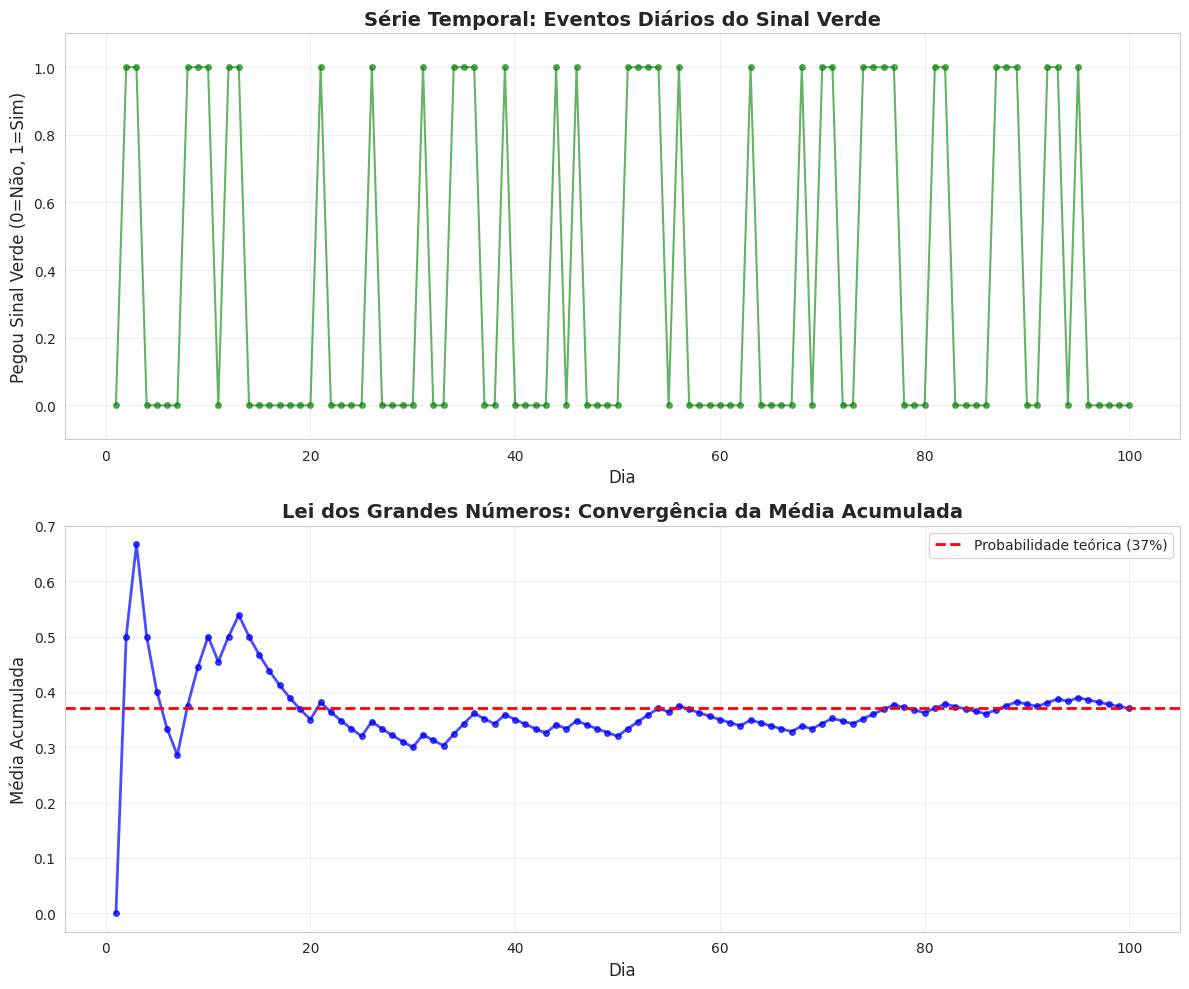


ANÁLISE ESTATÍSTICA DA SÉRIE TEMPORAL

Total de dias observados: 100
Quantidade de vezes que pegou verde: 37
Proporção observada final: 0.3700
Probabilidade teórica esperada: 0.3700
Diferença: 0.0000

Interpretação: A média acumulada converge para a probabilidade teórica
à medida que aumentamos o número de observações (Lei dos Grandes Números).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo do seaborn
sns.set_style("whitegrid")

# Carregar os dados
df = pd.read_csv('/workspaces/Stats-In-Codespace/Aula2/julio/serie_temporal_sinal_verde.csv')

print(df.head())

# Criar figura com subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Série temporal dos eventos (pegou verde ou não)
axes[0].plot(df['dia'], df['pegou_verde'], marker='o', linestyle='-', 
             color='green', alpha=0.6, markersize=4)
axes[0].set_xlabel('Dia', fontsize=12)
axes[0].set_ylabel('Pegou Sinal Verde (0=Não, 1=Sim)', fontsize=12)
axes[0].set_title('Série Temporal: Eventos Diários do Sinal Verde', fontsize=14, fontweight='bold')
axes[0].set_ylim(-0.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Plot 2: Média acumulada ao longo do tempo
axes[1].plot(df['dia'], df['media_acumulada'], marker='o', linestyle='-', 
             color='blue', alpha=0.7, markersize=4, linewidth=2)
axes[1].axhline(y=0.37, color='red', linestyle='--', linewidth=2, 
                label='Probabilidade teórica (37%)')
axes[1].set_xlabel('Dia', fontsize=12)
axes[1].set_ylabel('Média Acumulada', fontsize=12)
axes[1].set_title('Lei dos Grandes Números: Convergência da Média Acumulada', 
                  fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Ajustar layout
plt.tight_layout()
plt.show()

# Estatísticas descritivas
print("\n" + "="*60)
print("ANÁLISE ESTATÍSTICA DA SÉRIE TEMPORAL")
print("="*60)
print(f"\nTotal de dias observados: {len(df)}")
print(f"Quantidade de vezes que pegou verde: {df['pegou_verde'].sum()}")
print(f"Proporção observada final: {df['media_acumulada'].iloc[-1]:.4f}")
print(f"Probabilidade teórica esperada: 0.3700")
print(f"Diferença: {abs(df['media_acumulada'].iloc[-1] - 0.37):.4f}")
print("\nInterpretação: A média acumulada converge para a probabilidade teórica")
print("à medida que aumentamos o número de observações (Lei dos Grandes Números).")
print("="*60)

## Exemplo Bernoulli

Laboratório Python: Simulando a Distribuição Bernoulli

Cenário: Estamos modelando a confiabilidade de um sensor de pedágio eletrônico.

• Sucesso (1): O sensor lê a tag e a cancela abre.
• Fracasso (0): O sensor falha e a cancela permanece fechada.
• Parâmetro (p): A probabilidade teórica de sucesso do equipamento é de 80% (p=0.8).

Primeiros 20 carros: [1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1]


/tmp/ipykernel_1762/3039881096.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dados_pedagio, palette='viridis', order=[0, 1])


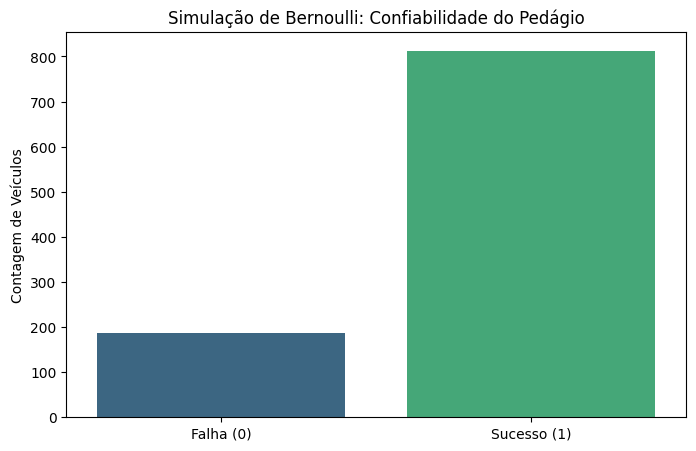

------------------------------
COMPARATIVO TEORIA vs PRÁTICA
------------------------------
Média Teórica (p): 0.8000
Média da Amostra:  0.8130
------------------------------
Variância Teórica (p*(1-p)): 0.1600
Variância da Amostra:       0.1520


In [2]:
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuração dos Parâmetros (Teoria)
p_sucesso = 0.8  # Probabilidade de abrir a cancela (80%)
n_carros = 1000  # Tamanho da amostra (número de ensaios)

# 2. Gerando a Simulação (A Distribuição de Bernoulli)
# A função rvs (Random Variates) gera os números 0 ou 1 com base no p
dados_pedagio = bernoulli.rvs(p_sucesso, size=n_carros)

# Visualizando os primeiros 20 resultados para tornar concreto
print(f"Primeiros 20 carros: {dados_pedagio[:20]}")
# 0 = Falha, 1 = Sucesso

# 3. Visualização Gráfica
plt.figure(figsize=(8, 5))
# garantir a ordem das categorias 0 e 1
sns.countplot(x=dados_pedagio, palette='viridis', order=[0, 1])
plt.title('Simulação de Bernoulli: Confiabilidade do Pedágio')
# definir ambos os ticks (0 e 1) para evitar mismatch entre localizações e rótulos
plt.xticks([0, 1], ['Falha (0)', 'Sucesso (1)'])
plt.ylabel('Contagem de Veículos')
plt.show()

# 4. Validando a Matemática (Callback à Aula Teórica)
# Cálculo Teórico (Fórmulas do Fávero)
media_teorica = p_sucesso
variancia_teorica = p_sucesso * (1 - p_sucesso)

# Cálculo Empírico (O que aconteceu na simulação)
media_amostral = np.mean(dados_pedagio)
variancia_amostral = np.var(dados_pedagio)

print("-" * 30)
print(f"COMPARATIVO TEORIA vs PRÁTICA")
print("-" * 30)
print(f"Média Teórica (p): {media_teorica:.4f}")
print(f"Média da Amostra:  {media_amostral:.4f}")
print("-" * 30)
print(f"Variância Teórica (p*(1-p)): {variancia_teorica:.4f}")
print(f"Variância da Amostra:       {variancia_amostral:.4f}")

Para a Distribuição Binomial, o conceito chave a transmitir é que ela é simplesmente uma soma de n ensaios de Bernoulli independentes. Se Bernoulli é o "tijolo", a Binomial é o "muro".
Vamos manter o contexto do Pedágio Automático (Sem Parar) para o Callback e o Concreto:
• Antes (Bernoulli): Olhávamos 1 carro. Passou ou travou?
• Agora (Binomial): Vamos olhar para filas de 10 carros. Em cada grupo de 10, quantos conseguem passar direto?


Cenário: O engenheiro está analisando o fluxo em horário de pico. Ele observa grupos de 10 veículos (n=10) chegando ao pórtico.
• Probabilidade (p): A eficiência continua 80% (p=0.8).
• Variável Aleatória (X): Número de sucessos (aberturas) em cada grupo de 10 carros.

Sucessos nos primeiros 20 grupos: [10  9  8  5  8  8  9  7 10  8 10  8  8  7 10  8  7  6  9  9]


/tmp/ipykernel_1762/3052473324.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dados_grupos, palette='viridis', order=range(n_ensaios + 1))


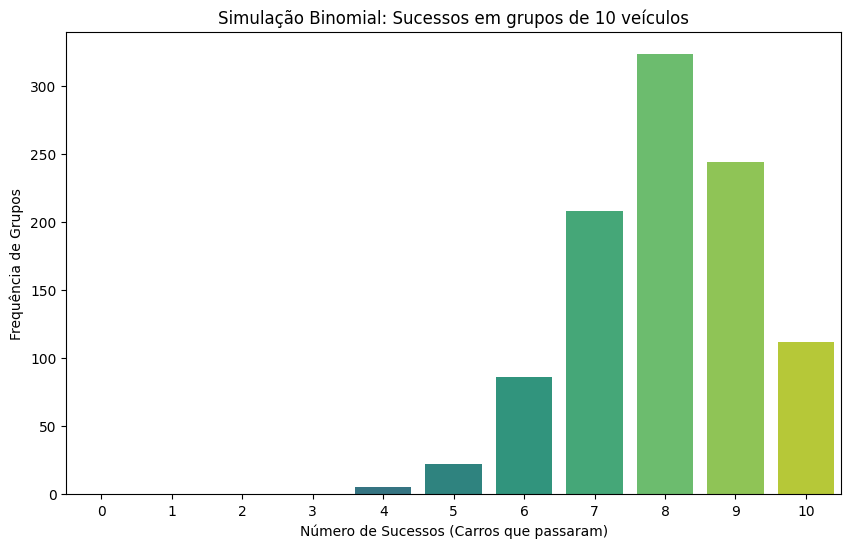

------------------------------
COMPARATIVO TEORIA vs PRÁTICA (BINOMIAL)
------------------------------
Média Teórica (n*p):        8.0000
Média da Amostra:           8.0020
------------------------------
Variância Teórica (n*p*q):  1.6000
Variância da Amostra:       1.5220


In [3]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuração dos Parâmetros
p_sucesso = 0.8      # Chance de abrir a cancela (o mesmo da Bernoulli)
n_ensaios = 10       # Agora olhamos grupos de 10 carros (tamanho da fila)
N_experimentos = 1000 # Quantas vezes vamos observar esses grupos de 10

# 2. Gerando a Simulação (A Distribuição Binomial)
# binom.rvs gera o número de sucessos em cada grupo de 10
dados_grupos = binom.rvs(n=n_ensaios, p=p_sucesso, size=N_experimentos)

# Visualizando os primeiros 20 resultados para tornar Concreto
# Ex: "8" significa que no grupo de 10 carros, 8 passaram e 2 travaram.
print(f"Sucessos nos primeiros 20 grupos: {dados_grupos[:20]}")

# 3. Visualização Gráfica
plt.figure(figsize=(10, 6))
# O eixo X vai de 0 a 10 (máximo de sucessos possíveis)
sns.countplot(x=dados_grupos, palette='viridis', order=range(n_ensaios + 1))
plt.title(f'Simulação Binomial: Sucessos em grupos de {n_ensaios} veículos')
plt.xlabel('Número de Sucessos (Carros que passaram)')
plt.ylabel('Frequência de Grupos')
plt.show()

# 4. Validando a Matemática (Callback à Teoria)
# Fórmulas do Fávero para Binomial (Média = n*p, Variância = n*p*q)
media_teorica = n_ensaios * p_sucesso
variancia_teorica = n_ensaios * p_sucesso * (1 - p_sucesso)

# Cálculo Empírico (O que aconteceu na simulação)
media_amostral = np.mean(dados_grupos)
variancia_amostral = np.var(dados_grupos)

print("-" * 30)
print(f"COMPARATIVO TEORIA vs PRÁTICA (BINOMIAL)")
print("-" * 30)
print(f"Média Teórica (n*p):        {media_teorica:.4f}")
print(f"Média da Amostra:           {media_amostral:.4f}")
print("-" * 30)
print(f"Variância Teórica (n*p*q):  {variancia_teorica:.4f}")
print(f"Variância da Amostra:       {variancia_amostral:.4f}")

## Poisson

"Na Binomial, nós tínhamos um limite rígido: olhávamos para um grupo fixo de 10 carros (n=10) e contávamos quantos passavam. Mas a rodovia não para de funcionar para formarmos grupos de 10. O tráfego é um fluxo contínuo. A Distribuição Poisson surge quando levamos a Binomial ao limite: imaginem que o número de carros possíveis (n) é enorme (quase infinito), mas a chance de um carro específico passar naquele exato segundo (p) é muito pequena. Quando n→∞ e p→0, mantendo a média constante, a Binomial se transforma em Poisson."


"Esqueçam o sucesso/fracasso individual da cancela por um momento. Agora, você é o gerente de operações da concessionária e precisa dimensionar a praça de pedágio. Sua pergunta não é 'o carro passou?', mas sim: 'Quantos veículos chegam à praça de pedágio por minuto?'
• Pode chegar 0 carros? Sim.
• Podem chegar 5? Sim.
• Podem chegar 50? Teoricamente sim, mas é improvável.
• Existe um limite máximo fixo (n)? Não, o fluxo é aberto.
A Poisson modela a contagem de eventos em um intervalo de tempo ou espaço contínuo. No nosso caso: Chegadas de veículos por minuto."
A Matemática : A distribuição tem apenas um parâmetro: λ (Lambda), que representa a taxa média de ocorrência. A probabilidade de chegarem exatamente k carros é dada por: P(X=k)= e^λ⋅λ^k / k!
 ​

3. Curiosidade 
"Aqui está uma propriedade matemática fascinante e exclusiva da Poisson que vocês podem usar como ferramenta de diagnóstico rápido. Na Poisson, a Média é igual à Variância. 
E(X)=λ
 
Var(X)=λ
Por que isso importa? Se vocês pegarem os dados de tráfego da rodovia e a variância for muito maior que a média (o que chamamos de superdispersão), vocês saberão imediatamente que o modelo Poisson está errado e falhará nas previsões. Nesse caso, precisariam usar a Binomial Negativa. A Poisson descreve o tráfego 'comportado'; a superdispersão descreve o caos."

Vamos simular a chegada de veículos em um minuto.
• Cenário: Em média, chegam 5 carros por minuto (λ=5) em uma cabine.
• Objetivo: Simular 1000 minutos de operação e ver como a aleatoriedade se comporta.

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1762/1814731650.py:22: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Simulação Poisson: Chegadas por Minuto (Média $\lambda$={lambda_chegadas})')
/tmp/ipykernel_1762/1814731650.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dados_chegadas, palette='viridis')


Chegadas nos primeiros 20 minutos: [ 4  2  5  2  4  6  3 11  3  5  1  2  3  7  7  6  4  3  7  4]


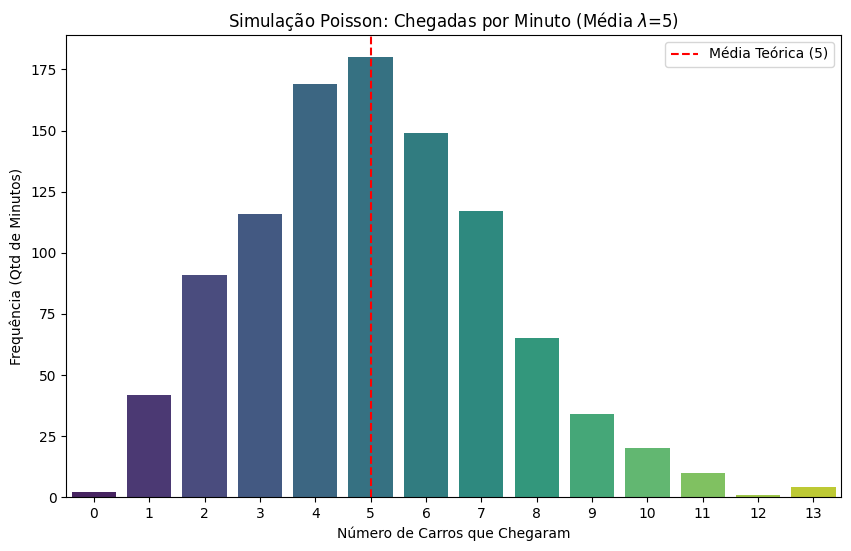

----------------------------------------
DIAGNÓSTICO POISSON (A PROPRIEDADE DE OURO)
----------------------------------------
Média Teórica (Lambda):   5.0000
Média da Amostra:         5.0610
----------------------------------------
Variância Teórica (Lambda): 5.0000
Variância da Amostra:       5.0813
----------------------------------------
CONCLUSÃO: Média e Variância próximas. O modelo Poisson se ajusta bem!


In [4]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuração do Parâmetro (A taxa média)
lambda_chegadas = 5  # média de 5 carros por minuto
n_minutos = 1000     # Simular 1000 minutos de operação

# 2. Gerando a Simulação (Distribuição Poisson)
# poisson.rvs gera a contagem de chegadas para cada minuto
dados_chegadas = poisson.rvs(mu=lambda_chegadas, size=n_minutos)

# Visualizando os primeiros 20 minutos
print(f"Chegadas nos primeiros 20 minutos: {dados_chegadas[:20]}")
# Ex: [4, 6, 5, 2...] significa: no 1º min chegaram 4, no 2º chegaram 6...

# 3. Visualização Gráfica
plt.figure(figsize=(10, 6))
# Plotamos a frequência de minutos em que ocorreram k chegadas
sns.countplot(x=dados_chegadas, palette='viridis')
plt.title(f'Simulação Poisson: Chegadas por Minuto (Média $\lambda$={lambda_chegadas})')
plt.xlabel('Número de Carros que Chegaram')
plt.ylabel('Frequência (Qtd de Minutos)')
plt.axvline(x=lambda_chegadas, color='red', linestyle='--', label=f'Média Teórica ({lambda_chegadas})')
plt.legend()
plt.show()

# 4. Validando a Propriedade Mágica (Média = Variância)
media_amostral = np.mean(dados_chegadas)
variancia_amostral = np.var(dados_chegadas)

print("-" * 40)
print(f"DIAGNÓSTICO POISSON (A PROPRIEDADE DE OURO)")
print("-" * 40)
print(f"Média Teórica (Lambda):   {lambda_chegadas:.4f}")
print(f"Média da Amostra:         {media_amostral:.4f}")
print("-" * 40)
print(f"Variância Teórica (Lambda): {lambda_chegadas:.4f}")
print(f"Variância da Amostra:       {variancia_amostral:.4f}")
print("-" * 40)

if abs(media_amostral - variancia_amostral) < 0.5:
    print("CONCLUSÃO: Média e Variância próximas. O modelo Poisson se ajusta bem!")
else:
    print("CONCLUSÃO: Há sinais de dispersão. Poisson pode não ser ideal.")

"Observem que, embora a média seja 5 (a barra mais alta ou próxima dela), a cauda do gráfico se estende para a direita. Haverá minutos raros em que chegarão 10 ou 12 carros. Para um engenheiro de transportes, a cauda da direita é o perigo. É nesses minutos raros de alta chegada (muito acima do λ) que as filas se formam e os acidentes acontecem. Projetamos a rodovia não apenas para a média, mas para suportar essa variabilidade que a Poisson nos ajuda a calcular,."

## Normal (Gaussiana)

"Até agora, falamos de variáveis discretas: o carro passou ou não (Bernoulli/Binomial) ou quantos carros chegaram (Poisson). Mas o mundo não é feito apenas de números inteiros. Na Aula 1, calculamos média e desvio padrão. A Distribuição Normal é o modelo matemático onde esses dois parâmetros (μ e σ) contam a história completa. Ela é a ponte que conecta a estatística descritiva que vimos antes com a capacidade de prever o comportamento de variáveis contínuas, como o tempo de deslocamento entre duas zonas de tráfego."
2. (O Cenário Real: Velocidade na Via)
"Imaginem um radar de velocidade em uma rodovia onde o limite é 90 km/h. Diferente da contagem de carros (que são números inteiros), a velocidade é contínua. Um carro pode passar a 88,5 km/h, outro a 90,1 km/h, outro a 85 km/h.
A Distribuição Normal nos diz que:
• A maioria dos motoristas vai dirigir perto da velocidade média da via (o pico do sino).
• Alguns dirigirão um pouco mais rápido ou mais devagar (o corpo do sino).
• Muito poucos dirigirão extremamente devagar ou como pilotos de corrida (as caudas do sino).
Essa simetria em forma de sino é descrita por apenas dois números: onde está o centro (Média μ) e o quão 'espalhados' estão os motoristas (Desvio Padrão σ)."
3. Curiosidade (O "Poder Mágico" do Teorema do Limite Central)
"Por que essa distribuição é tão obcecada por engenheiros? A lei matemática chamada Teorema do Limite Central (TLC) diz que, se você pegar amostras grandes de qualquer distribuição (mesmo que o tráfego seja caótico e não normal), a média dessas amostras seguirá uma Distribuição Normal,.
Por que isso importa? Porque nos permite calcular margens de erro e intervalos de confiança. Se você projeta uma ponte ou um tempo de semáforo, você usa a Normal para garantir que o sistema funcione para 95% ou 99% dos casos, ignorando apenas os extremos raros (os 3σ)."

Vamos simular as velocidades em um trecho de rodovia para responder a uma pergunta de engenharia: Qual a probabilidade de um veículo ser multado?
• Cenário: Velocidade média operacional (μ) = 85 km/h.
• Variabilidade (σ): Desvio padrão = 5 km/h.
• Radar: Multa quem passar acima de 90 km/h.

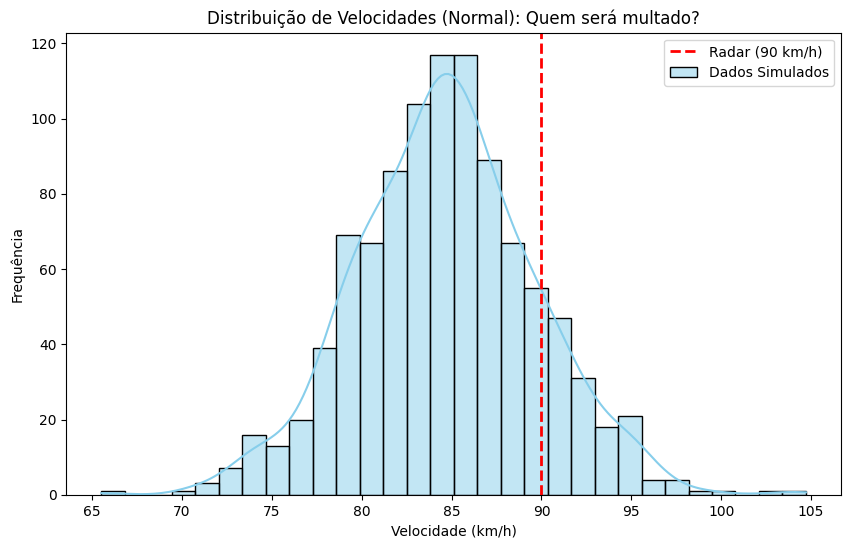

----------------------------------------
ANÁLISE DE RISCO (RADAR)
----------------------------------------
Média da Via: 85 km/h | Desvio Padrão: 5 km/h
Probabilidade Teórica de Multa (>90km/h): 15.87%
Multados na Simulação (n=1000):     142 veículos (14.20%)
----------------------------------------


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# 1. Configuração dos Parâmetros
media_velocidade = 85  # km/h
desvio_padrao = 5      # km/h
n_veiculos = 1000      # Tamanho da amostra
limite_radar = 90      # Velocidade de corte para multa

# 2. Gerando a Simulação (Distribuição Normal)
# norm.rvs gera números aleatórios seguindo a curva normal
dados_velocidade = norm.rvs(loc=media_velocidade, scale=desvio_padrao, size=n_veiculos)

# 3. Visualização Gráfica
plt.figure(figsize=(10, 6))

# Histograma dos dados simulados
sns.histplot(dados_velocidade, kde=True, color='skyblue', bins=30, label='Dados Simulados')

# Linha do Radar
plt.axvline(x=limite_radar, color='red', linestyle='--', linewidth=2, label=f'Radar ({limite_radar} km/h)')

plt.title('Distribuição de Velocidades (Normal): Quem será multado?')
plt.xlabel('Velocidade (km/h)')
plt.ylabel('Frequência')
plt.legend()
plt.show()

# 4. Cálculo de Probabilidades (A Engenharia por trás do gráfico)
# Probabilidade Teórica: Qual a área da curva ACIMA de 90 km/h?
# sf (Survival Function) = 1 - cdf (Cumulative Distribution Function)
prob_multa_teorica = norm.sf(limite_radar, loc=media_velocidade, scale=desvio_padrao)

# Cálculo Empírico na nossa simulação
multados_simulacao = np.sum(dados_velocidade > limite_radar)
prob_multa_empirica = multados_simulacao / n_veiculos

print("-" * 40)
print(f"ANÁLISE DE RISCO (RADAR)")
print("-" * 40)
print(f"Média da Via: {media_velocidade} km/h | Desvio Padrão: {desvio_padrao} km/h")
print(f"Probabilidade Teórica de Multa (>90km/h): {prob_multa_teorica:.2%}")
print(f"Multados na Simulação (n={n_veiculos}):     {multados_simulacao} veículos ({prob_multa_empirica:.2%})")
print("-" * 40)

## Exponencial

Lembram-se do exemplo de Poisson que acabamos de rodar? Nós contávamos quantos carros chegavam ao pedágio em 1 minuto (uma variável discreta). A Distribuição Exponencial é o inverso disso. Em vez de perguntar 'quantos carros chegam?', nós perguntamos: 'Quanto tempo passa entre a chegada de um carro e o próximo?' Estamos saindo da contagem (discreta) e voltando para o tempo (contínua), mas mantendo a mesma lógica de eventos aleatórios."
2.  (O Cenário Real: Headway)
"Imaginem que vocês estão na beira da rodovia com um cronômetro. Passou um carro, você dispara o cronômetro. Passou o próximo, você para. Esse intervalo de tempo entre veículos consecutivos é o que chamamos em engenharia de tráfego de Headway.
• Às vezes, dois carros passam quase colados (tempo muito curto).
• Às vezes, demora um pouco mais.
• Raramente, a estrada fica vazia por muito tempo.
A Distribuição Exponencial modela exatamente esse tempo de espera entre eventos de um processo de Poisson. Ela é fundamental para calcular a capacidade da via: se o headway médio for muito pequeno, a via está saturada e o risco de colisão traseira aumenta."
A Matemática: Se os carros chegam a uma taxa média de λ (ex: 5 carros por minuto), o tempo médio entre os carros (E(X)) é o inverso dessa taxa (1/λ minutos).
3. Curiosidade (A Falta de Memória)
"Aqui está a propriedade mais contraintuitiva e fascinante dessa distribuição, chamada de Propriedade da Falta de Memória (Memoryless Property).
Imaginem que vocês estão esperando um ônibus que segue rigorosamente uma distribuição exponencial (o que é raro, mas vamos supor). Você já esperou 20 minutos. A chance de o ônibus chegar nos próximos 5 minutos é exatamente a mesma do que se você tivesse acabado de chegar no ponto. O 'sistema' não se lembra de quanto tempo já passou. Na engenharia de confiabilidade, isso é usado para modelar componentes eletrônicos que não sofrem desgaste: a chance de falhar na próxima hora é constante, não importa se o componente é novo ou velho. Isso desafia nossa intuição, mas é matematicamente verdade para esta distribuição."

Vamos simular o Headway (tempo entre veículos).
• Cenário: O fluxo é o mesmo do exercício anterior: 5 carros por minuto (λ=5).
• Pergunta: Qual é a distribuição dos intervalos de tempo (em minutos) entre esses carros?
• Teoria: Esperamos que o tempo médio seja 1/5=0,2 minutos (ou 12 segundos).

<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1762/1175733024.py:18: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Distribuição Exponencial: Tempo entre Chegadas (Headway)\nTaxa ($\lambda$) = {lambda_chegadas} carros/min')


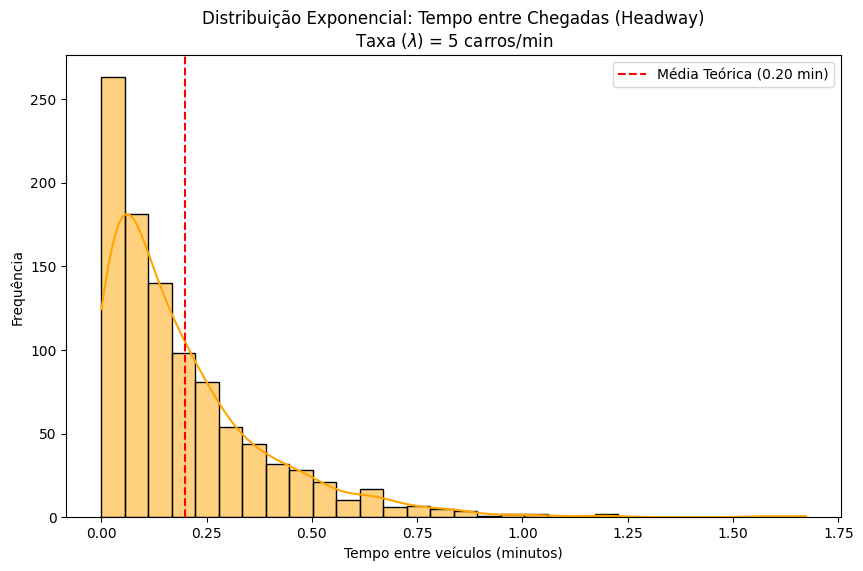

----------------------------------------
ANÁLISE DE FLUXO (HEADWAY)
----------------------------------------
Taxa de Chegada (Poisson): 5 carros/min
Tempo Médio Teórico (1/lambda): 0.2000 min
Tempo Médio na Simulação:       0.1946 min
----------------------------------------
Nota: Na distribuição exponencial, Média = Desvio Padrão
Desvio Padrão da Simulação:     0.2005


In [6]:
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuração dos Parâmetros
lambda_chegadas = 5  # carros por minuto (taxa média)
scale_param = 1 / lambda_chegadas  # O tempo médio entre chegadas é 1/lambda
n_carros = 1000      # Observar 1000 intervalos

# 2. Gerando a Simulação (Distribuição Exponencial)
# A função expon.rvs usa 'scale' que é igual a 1/lambda (média)
dados_headway = expon.rvs(scale=scale_param, size=n_carros)

# 3. Visualização Gráfica
plt.figure(figsize=(10, 6))
sns.histplot(dados_headway, kde=True, color='orange', bins=30)
plt.title(f'Distribuição Exponencial: Tempo entre Chegadas (Headway)\nTaxa ($\lambda$) = {lambda_chegadas} carros/min')
plt.xlabel('Tempo entre veículos (minutos)')
plt.ylabel('Frequência')

# Linha da média teórica
plt.axvline(x=scale_param, color='red', linestyle='--', label=f'Média Teórica ({scale_param:.2f} min)')
plt.legend()
plt.show()

# 4. Validando a Matemática
media_amostral = np.mean(dados_headway)
# Na exponencial, o desvio padrão teórico é igual à média (1/lambda)
desvio_padrao_amostral = np.std(dados_headway)

print("-" * 40)
print(f"ANÁLISE DE FLUXO (HEADWAY)")
print("-" * 40)
print(f"Taxa de Chegada (Poisson): {lambda_chegadas} carros/min")
print(f"Tempo Médio Teórico (1/lambda): {scale_param:.4f} min")
print(f"Tempo Médio na Simulação:       {media_amostral:.4f} min")
print("-" * 40)
print(f"Nota: Na distribuição exponencial, Média = Desvio Padrão")
print(f"Desvio Padrão da Simulação:     {desvio_padrao_amostral:.4f}")

1. O Gráfico: "Observem que o gráfico começa alto na esquerda e desce rapidamente. Isso significa que intervalos curtos são muito mais comuns do que intervalos longos. A maioria dos carros passa logo após o anterior (perto de 0 a 0.2 minutos). Intervalos longos (tipo esperar 1 minuto sem passar carro) são raros (a cauda longa)."
2. Aplicação em Segurança Viária: "Como engenheiros, vocês olham para a parte esquerda do gráfico (tempos curtos). Se muitos veículos tiverem headway menor que 2 segundos (0.03 min), o risco de colisão é altíssimo. A distribuição exponencial nos ajuda a calcular essa probabilidade de risco."
3. Conexão Teórica: "Vejam que a média e o desvio padrão deram valores muito próximos. Essa é uma assinatura da distribuição exponencial (assim como na Poisson a média era igual à variância). Se seus dados de tempo não tiverem essa característica, talvez vocês precisem de uma distribuição mais complexa, como a Weibull ou Gama (que veremos em análise de sobrevivência no futuro)."